# **Non-linear models: extended Kalman filter**

For this example we will be using the same target model as previuosly but using a non-linear sensor model.

In [7]:
import numpy as np 
from datetime import datetime, timedelta 
start_time = datetime.now()
np.random.seed(1313)

## Create a Target
As the other example, the target will move with near constant velocity NE from 0.0

In [8]:
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, ConstantVelocity
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState

# Transition Model
transition_model = CombinedLinearGaussianTransitionModel(
    [ConstantVelocity(0.05),
     ConstantVelocity(0.5)]
)

truth = GroundTruthPath([GroundTruthState([0,1,0,1], timestamp=start_time)])

for k in range(1,21): 
    truth.append(GroundTruthState(
        transition_model.function(truth[k-1], noise = True, time_interval = timedelta(seconds=1)),
        timestamp=start_time+timedelta(seconds=k)
    ))

Now let's plot this.

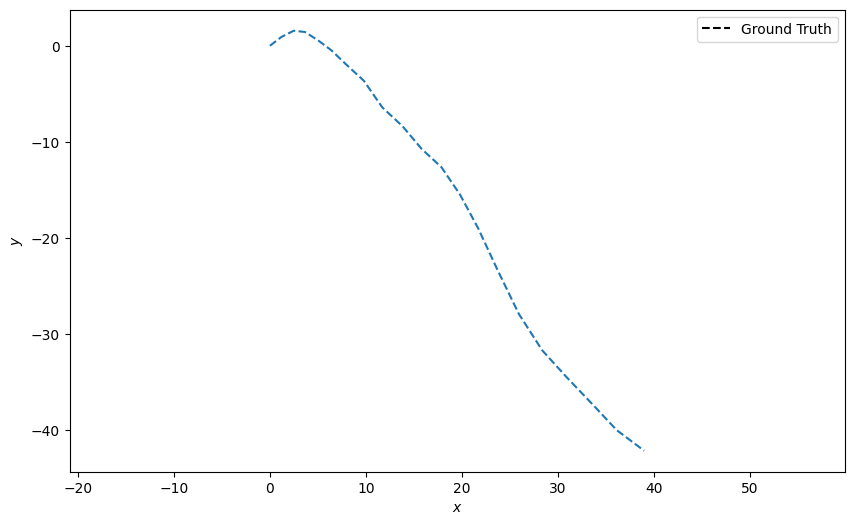

In [9]:
from stonesoup.plotter import Plotter
plotter = Plotter()
plotter.plot_ground_truths(truth, [0,2])

## A bearing-range sensor
We are going to simulate a 2d bearing-range sensor. An example could be de `CartesianToBearingRange` class. This takes the Cartesian state input and returnd a relative bearing and range to target. 

In [11]:
from stonesoup.models.measurement.nonlinear import CartesianToBearingRange

# placing the sensor off-centre
sensor_x = 50 
sensor_y = 0 

measurement_model = CartesianToBearingRange(
    ndim_state=4, 
    mapping=(0,2), 
    noise_covar = np.diag(
        [np.radians(0.2),1] # Covariance matrix. 0.2 degree variance in
    ),
    # bearing and 1 meter in range
    translation_offset = np.array([
        [sensor_x],
        [sensor_y]]
    ) # offset measurements to location of sensor in cartesian
)

Create a set of detections using this sensor model:

In [12]:
from stonesoup.types.detection import Detection

measurements = []
for state in truth: 
    measurement = measurement_model.function(state, noise=True)
    measurements.append(Detection(
        measurement, 
        timestamp=state.timestamp, 
        measurement_model = measurement_model
    ))

Now we plot the measurements. Where the model is nonlinear, the plotting function uses the inverse function to get coordinates

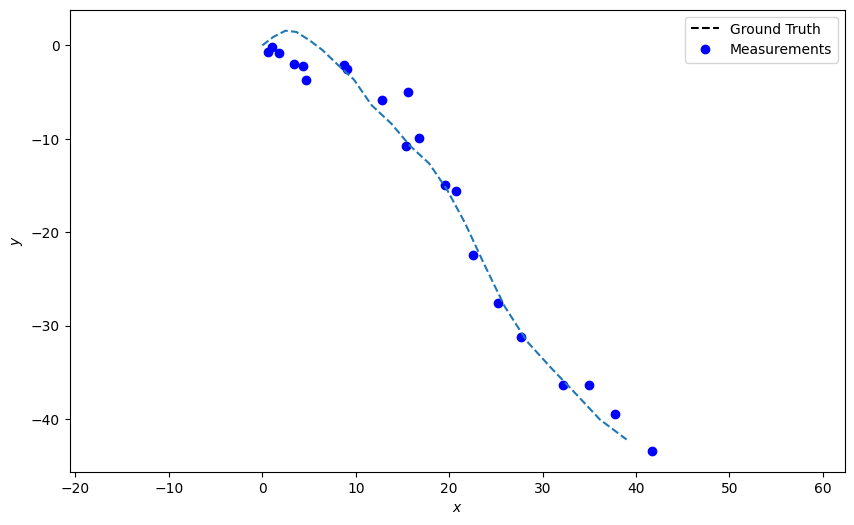

In [13]:
plotter.plot_measurements(measurements, [0,2])
plotter.fig

## Set up the extended Kalman Filter

* Now we create the predictor and updater. 
* The predictor takes a transition model and the updater a measurement model. 

Note: if either of these models are linear then the extended predictor/updater defaults to its Kalman equivalent. In fact, the extended Kalman filter classes inherit nearly all of their functionality from the Kalman classes. The only difference being that instead of returning the matrix, in the extended version the `matrix()` functions returns a Jacobian.

In [15]:
from stonesoup.predictor.kalman import ExtendedKalmanPredictor
predictor = ExtendedKalmanPredictor(transition_model)

from stonesoup.updater.kalman import ExtendedKalmanUpdater
updater = ExtendedKalmanUpdater(measurement_model)

## Run the extended Kalman filter
First we create a prior state.

In [16]:
from stonesoup.types.state import GaussianState
prior = GaussianState([[0], [1], [0], [1]], np.diag([1.5, 0.5, 1.5, 0.5]), timestamp=start_time)

Iterate over hypotheses and place in a track.

In [17]:
from stonesoup.types.hypothesis import SingleHypothesis
from stonesoup.types.track import Track

track = Track()
for measurement in measurements:
    prediction = predictor.predict(prior, timestamp=measurement.timestamp)
    hypothesis = SingleHypothesis(prediction, measurement)  # Group a prediction and measurement
    post = updater.update(hypothesis)
    track.append(post)
    prior = track[-1]

Plot the resulting track complete with error ellipses at each estimate.

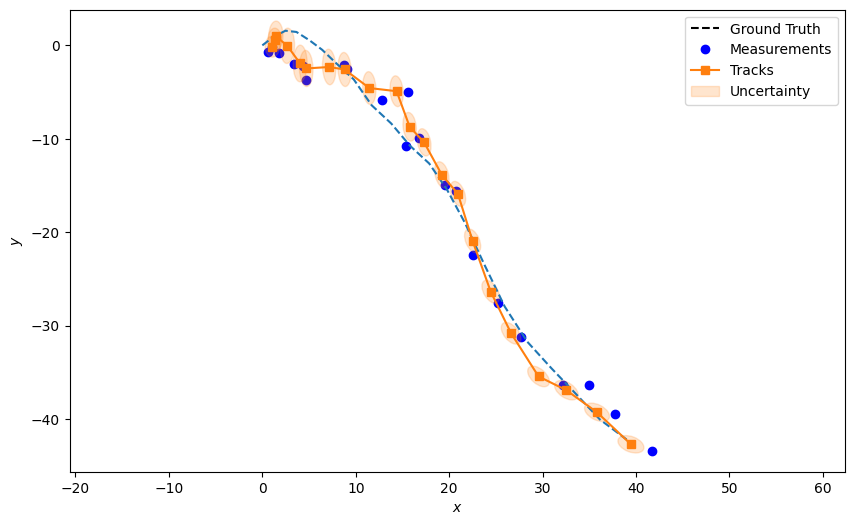

In [18]:
plotter.plot_tracks(track, [0, 2], uncertainty=True)
plotter.fig